In [1]:
# Set the matplotlib magic. This line is specific to ipython notebooks.
%matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# Import some useful module.
import time
from matplotlib import pyplot as plt
from IPython.display import HTML
import numpy as np
import math

# Import the system module.
import mag_lev

In [2]:
# Format Plots
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 150

# Change font
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

## Constants
These are computed based on the analysis from `model_exploration.ipynb`

In [174]:
MAX_VOLTAGE = 10.0                   # [V]
R = 2.41                             # Coil Resistance [ohms]
#L = 0.017
L = 0.014539394378662111             # Inductance [H]
c_I_to_V_h = 0.49895169189038646    # Computed scaling constant between electromagnet current and hall voltage
#c_I_to_V_h = 0.48                    # Hand-adjusted scaling constant - Likely caused by resistor value being slightly off

# Lumped parameter constants for V_h to position
hall_params = [2.59096138e-05, 2.49438901e+00, 1.35877620e-02]

## Functions
These functions use the above constants and are based on relationships discovered in the file `model_exploration.ipynb`

In [175]:
# Modeling Functions
def PWMtoVolts(PWM, max_volts):
    return PWM/255 * max_volts

def voltsToPWM(V_e, max_volts):
    return V_e/max_volts * 225

def currentToHallVoltage(I):
    return c_I_to_V_h * I

def computeSteadyStateCurrent(PWM):
    V_e = PWMtoVolts(PWM, MAX_VOLTAGE)
    I = V_e / R
    return I

def convertToDistance(V_h, I):
    """Computes distance of permanent magnet from electromagnet based on
    input hall voltage by subtracting contribution from electromagnet """

    # Check for clipping
    if V_h > 4:
        y = 0.015
        print("Warning: Clipping in hall voltage - check gains and that the magnet isn't too close")
        return y
    
    # Compute hall voltage contribution from electromagnet
    V_h_from_e = c_I_to_V_h * I
    
    # Compute hall voltage contribution from magnet
    V_h_from_m = V_h - V_h_from_e
    
    # Convert from hall voltage to position
    y = voltToPos(V_h_from_m,  *hall_params)   

    # Cap y within range
    if np.iscomplex(y) or y > 0.1:
        y = 0.1
        print("Warning: magnet has probably fallen")

    elif y < 0.015:
        # We can't accurately measure less than 1.5cm away anyways
        y = 0.015
        print("Warning: magnet has moved too close to electromagnet")
        
    return y
        
    

def posToVolt(x, a, b, c):
    return a/((x + c)**3) + b

def voltToPos(x, a, b, c):
    return (a/(x - b))**(1/3) - c

## Controller


In [202]:
class MagLevController():
    def __init__(self, theoretical_dt=0.01, max_volts=10.0, object_mass=3.0e-3, object_start_dist=0.03):
        # Parameters
        self.max_volts = max_volts           # Default to 10 [V]
        self.mass = object_mass              # Permanent magnet mass [kg]
        self.theoretical_dt = theoretical_dt # Timestep for approximation [s]
        self.start_dist = object_start_dist  # Starting distance        
        
        # State vars
        self.dt = 0                     # Actual time since last timestep
        self.t = 0                      # Time to use in graphs and calculations (starts from 0)
        self.y = 0                      # Distance from electromagnet
        self.I = 0                      # Current
        self.V_e = 0                    # Electromagnet voltage command
        
        # Data logging
        self.t_list = []
        self.V_h_list = []
        self.y_list = []
        self.I_list = []
        
        self.magnet_V_h_list = []########### TEMP
        
        # Other vars
        self.wall_time = time.time()    # Output of time.time()
    
    def computeController(self):
        """Based on the current converted sensor reading, compute the next
        electromagnet voltage command to send to the plant"""
        return 0
    
    def reset(self):
        """Reset state variables"""
        self.dt = 0
        self.t = 0
        self.I = 0
        self.y = 0
    
    def run(self, end_t):
        """Create a simulation and run it for set amount of time"""
        self.reset()
        
        self.sys = mag_lev.MagLev()
        self.sys.start_system()
        self.sys.set_max_coil_voltage_magnitude(self.max_volts)
        self.sys.set_object_mass(self.mass)
        
        ###############################
        # TODO - hold object there and release once magnet is already on - aka move this into the loop
        self.sys.hold_magnet_at_distance(self.start_dist)
        
#         self.V_e = 8
#         PWM = voltsToPWM(self.V_e, self.max_volts)
#         self.sys.set_amplifier_input(PWM, self.sys.FORWARD) ### TODO: REMOVE THIS
        
        time.sleep(1)
        self.sys.release_magnet()
         ###############################
        
        
        
        # Initialize time
        self.wall_time = time.time()
        
        while self.t < end_t:   
            # Create timestep
#             time.sleep(self.theoretical_dt)
            
            # Update timing
            self.dt = time.time() - self.wall_time
            self.wall_time = time.time()
            self.t += self.dt
            
            # Update current
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Convert hall voltage into distance measurement
            V_h = self.sys.get_hall_voltage()
            
            #####################
#             self.I = computeSteadyStateCurrent(self.V_e) # TODOO ; REOMOVE THIS
            self.y = convertToDistance(V_h, self.I)
            # Compute hall voltage contribution from electromagnet
            V_h_from_e = c_I_to_V_h * self.I

            # Compute hall voltage contribution from magnet
            V_h_from_m = V_h - V_h_from_e
            self.magnet_V_h_list.append(V_h_from_m)
            #####################
            
            
            self.y = convertToDistance(V_h, self.I)
            
            self.V_e = 0#5
            PWM = voltsToPWM(self.V_e, self.max_volts)
            self.sys.set_amplifier_input(PWM, self.sys.FORWARD) ### TODO: REMOVE THIS
            
            
            
#             self.V_e = computeController()            
#             print(self.t)

            print(V_h, self.I)
        
            
            # Log data point
            self.t_list.append(self.t)
            self.V_h_list.append(V_h)
            self.y_list.append(self.y)
            self.I_list.append(self.I)
            
        self.sys.stop_system()
        
#         time.sleep(1)
#         self.anim = self.sys.create_system_animation();
    
    def logData(self):
        # TODO raise error if no data is saved
        pass

In [203]:
# MAX_VOLTAGE = 10.0                   # [V]
# R = 2.41                             # Coil Resistance [ohms]
# L = 0.014539394378662111   #0.017          # Inductance [H]
# c_I_to_V_h = 0.49895169189038646    # Computed scaling constant between electromagnet current and hall voltage
# #c_I_to_V_h = 0.48                    # Hand-adjusted scaling constant - Likely caused by resistor value being slightly off

# # Lumped parameter constants for V_h to position
# hall_params = [2.59096138e-05, 2.49438901e+00, 1.35877620e-02]

sim = MagLevController(theoretical_dt=0.00000000000000000000000000000001, 
                       max_volts=10.0, 
#                        object_mass=3.0e-3, 
                       object_start_dist=0.03)
sim.run(1)

Starting system...
System started
2.8044478207814745 0.0
2.804228308080827 0.0
2.8031036132466505 0.0
2.802647028457894 0.0
2.8009783475285457 0.0
2.799089367180067 0.0
2.7954242925253903 0.0
2.7922946467347383 0.0
2.788930307678519 0.0
2.7856588283250137 0.0
2.780954689871786 0.0
2.776261722984104 0.0
2.771034939307832 0.0
2.766559855521601 0.0
2.76160081181715 0.0
2.756041533100373 0.0
2.75115969923622 0.0
2.7452416544702576 0.0
2.738372338862193 0.0
2.730985968413854 0.0
2.725577301422621 0.0
2.7185069253678256 0.0
2.7091403822379725 0.0
2.702961925151336 0.0
2.697652004122488 0.0
2.6898548621865093 0.0
2.684260549784428 0.0
2.6785361989080556 0.0
2.6718423736218737 0.0
2.6660657090494504 0.0
2.6601645637161293 0.0
2.6537593571027007 0.0
2.649344901838873 0.0
2.6442283342980666 0.0
2.6402355274885223 0.0
2.634259713651659 0.0
2.629619335249529 0.0
2.624453289234915 0.0
2.6206573459122744 0.0
2.61467970739396 0.0
2.6114415307856866 0.0
2.6062516624671956 0.0
2.6029154290307135 0.0
2.

2.5091799655616365 0.0
2.5092411483329777 0.0
2.5092412129036172 0.0
2.5092178274980266 0.0
2.509287914299446 0.0
2.5091414165342263 0.0
2.509160334559504 0.0
2.509009329581133 0.0
2.509111602109005 0.0
2.50915850760047 0.0
2.5090385409879756 0.0
2.509253399180303 0.0
2.5092000558194436 0.0
2.509189196487613 0.0
2.5091013918380796 0.0
2.509361794409342 0.0
2.5091007723169345 0.0
2.5092617306697567 0.0
2.5092212994498304 0.0
2.5091798358422137 0.0
2.509210742517543 0.0
2.5092135808764704 0.0
2.5091298147151693 0.0
2.509207912947914 0.0
2.5093519791593306 0.0
2.509200186812151 0.0
2.509360856188949 0.0
2.509070678660519 0.0
2.5093564323535498 0.0
2.5089197358969804 0.0
2.5091342992949173 0.0
2.509438334732948 0.0
2.5090464877513208 0.0
2.5091023734481546 0.0
2.5092342422801455 0.0
2.509297915555394 0.0
2.5091594307985026 0.0
2.5092283201426397 0.0
2.509207559769133 0.0
2.5091222200573315 0.0
2.5092666444306464 0.0
2.5092108500761827 0.0
2.509199862138902 0.0
2.509297010955225 0.0
2.50914

2.5092529593358353 0.0
2.509215793212681 0.0
2.509358583345421 0.0
2.509121626272061 0.0
2.5092333466748027 0.0
2.5092276490613865 0.0
2.509238071937161 0.0
2.5092062842630347 0.0
2.509151289765633 0.0
2.5092707328324635 0.0
2.5090786354398102 0.0
2.5092143835239558 0.0
2.5093617554869665 0.0
2.5093808957624844 0.0
2.5092921174913165 0.0
2.509099175130761 0.0
2.5091849659666 0.0
2.509225008544453 0.0
2.5092722054235033 0.0
2.5092784069045706 0.0
2.5092535016258286 0.0
2.509231831470682 0.0
2.5093170392885953 0.0
2.509233547449729 0.0
2.509137963140819 0.0
2.509189390161468 0.0
2.509246100413776 0.0
2.5093009005993943 0.0
2.509331833869763 0.0
2.5093155290839224 0.0
2.509279958901354 0.0
2.509218545773117 0.0
2.5091769714258305 0.0
2.5091971522273626 0.0
2.5092363662169226 0.0
2.509215535751952 0.0
2.5090679862067624 0.0
2.509280783367544 0.0
2.509199528051263 0.0
2.509077183044676 0.0
2.5092212649643937 0.0
2.5092085400117288 0.0
2.509072271811538 0.0
2.5091474539278122 0.0
2.509011156

2.5093458701970457 0.0
2.50914554100583 0.0
2.509319447896272 0.0
2.5092031489430062 0.0
2.509201328652803 0.0
2.5092238735405408 0.0
2.509207831079415 0.0
2.509100648886435 0.0
2.5091586387068006 0.0
2.509290019074525 0.0
2.5091085697602615 0.0
2.509310357345215 0.0
2.5093052793270556 0.0
2.509039396819831 0.0
2.5092208192562975 0.0
2.509234312824521 0.0
2.509198431701501 0.0
2.509098496592538 0.0
2.50916257158795 0.0
2.5092283230272017 0.0
2.5090971856306883 0.0
2.509212957748199 0.0
2.5092715853616427 0.0
2.5091892597289154 0.0
2.509118151939362 0.0
2.509097826313552 0.0
2.5091510350371773 0.0
2.5092366674961206 0.0
2.5090778151560715 0.0
2.509167366801562 0.0
2.509088132839873 0.0
2.5092522205216716 0.0
2.5093118482243533 0.0
2.5092306581183403 0.0
2.5092396243660002 0.0
2.5091725016423765 0.0
2.5091046934244035 0.0
2.5091773590369812 0.0
2.5091325424854314 0.0
2.5092004056998305 0.0
2.5091232029070354 0.0
2.509324060425387 0.0
2.5091650799987364 0.0
2.509212382279035 0.0
2.5092190

System stopped


## Test Plots
These graphs depict dropping an unweighted magnet right before turning on the amplifier. They generally make sense, as the magnet falls a little before moving back up. Note that if the amplifer is turned up too high, we run into issues with clipping on the hall voltage, so I wouldn't go above 8ish volts (these tests were run with $V_e = 5$

Text(0.5, 0, 'Time (s)')

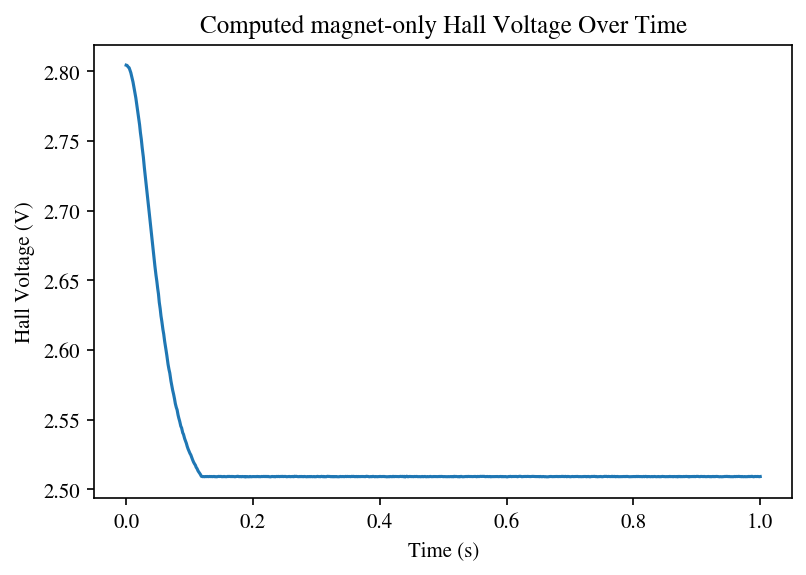

In [204]:
plt.plot(sim.t_list, sim.magnet_V_h_list)
plt.title("Computed magnet-only Hall Voltage Over Time")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

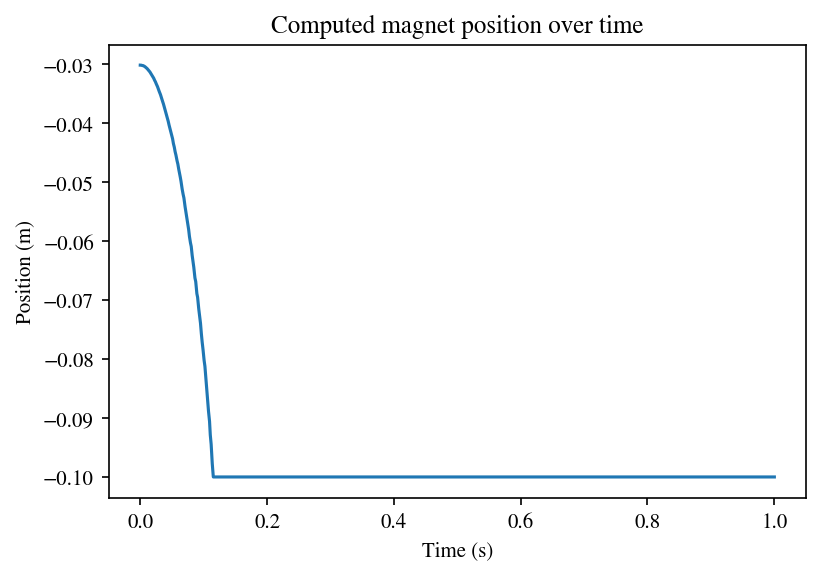

In [205]:
plt.plot(sim.t_list, -np.array(sim.y_list))
plt.title("Computed magnet position over time")
plt.ylabel("Position (m)")
plt.xlabel("Time (s)")

In [206]:
# # Plotting derivatives
# der = np.diff(sim.y_list) / np.diff(sim.t_list)
# x2 = (sim.t_list[:-1] + sim.t_list[1:]) / 2
# plt.plot(der)
# #plt.plot(x2, der, 'r', x, y, 'g', x, -np.sin(x),'b')

# Current vs position
# plt.plot(sim.I_list,-np.array(sim.y_list), '.')

Text(0.5, 0, 'Time (s)')

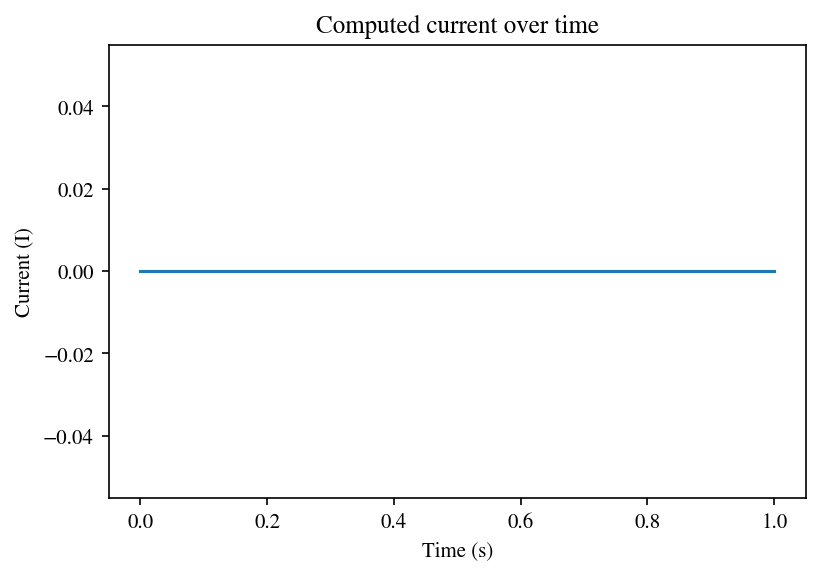

In [207]:
plt.plot(sim.t_list, sim.I_list)
plt.title("Computed current over time")
plt.ylabel("Current (I)")
plt.xlabel("Time (s)")

Text(0.5, 0, 'Time (s)')

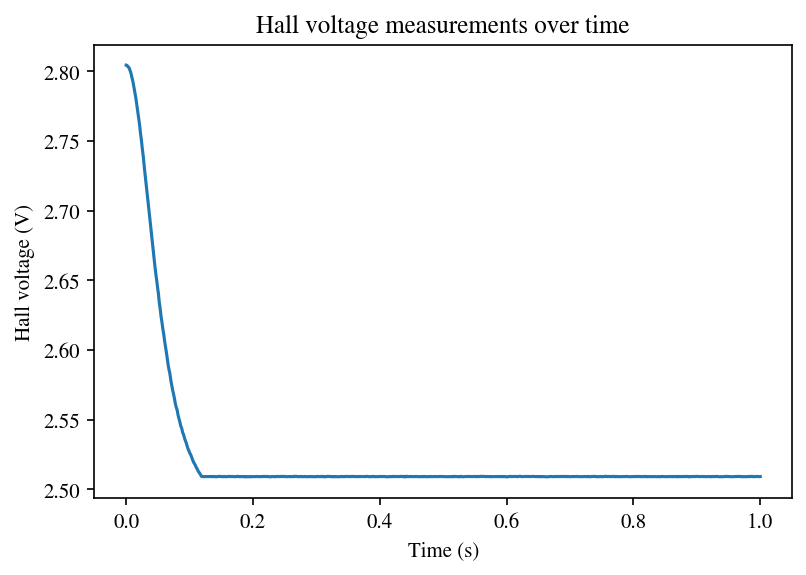

In [208]:
plt.plot(sim.t_list, sim.V_h_list)
plt.title("Hall voltage measurements over time")
plt.ylabel("Hall voltage (V)")
plt.xlabel("Time (s)")

In [183]:

convertToDistance(3.3278557876700194, 1.2448128614097769)

0.03600966328487579

In [184]:
V_h = 3.3278557876700194
I = 1.2448128614097769

# Compute hall voltage contribution from electromagnet
V_h_from_e = c_I_to_V_h * I
print(V_h_from_e)

# Compute hall voltage contribution from magnet
V_h_from_m = V_h - V_h_from_e
print(V_h_from_m)

# Convert from hall voltage to position
print(voltToPos(V_h_from_m,  *hall_params) )

0.6211014832873213
2.7067543043826983
0.03600966328487579


# Conclusions
- dip is caused when magnet is dropped but the electromagnet is not turned on until a little later (it falls as the magnet is "warming up")
- the little bit of noise at the beginning can be tuned out with increasing the inductance - however, don't make the inductance too big or the dynamics become incorrect
- if you turn on the electromagnet before dropping the magnet, be sure to change current accordingly
- we should add more error checking for clipping - the position measurements right now are faulty at steady-state because we're not accounting for the fact that the clipping is happening - this drove me nuts with debugging
- equally balancing gravity (as close as possible) with default mass happens at PWM 85, which translates to a voltage of approximately 3.77778

## Custom Model

This section contains code for a model that replicates the "real world" simulation as closely as possible. Note that this model is entirely independent from the "real world" simulation, and only re-uses constants. In other words, this model attempts to replicate the "real world" simulation behavior but never makes calls to the MagLev API

In [167]:
convertToDistance(4, 0)

0.015

In [209]:
# Creating our own model to compare to the "real world" model
class MagLevModel():
    def __init__(self, dt=0.001, max_volts=10.0, object_mass=3.0e-3, object_start_dist=0.03):
        # Parameters
        self.max_volts = max_volts          # Default to 10 [V]
        self.mass = object_mass             # Permanent magnet mass [kg]
        self.dt = dt                        # Timestep for approximation [s]
        self.start_dist = object_start_dist # Starting distance        
            
        # State variables
        self.V_e = 0                    # Electromagnet voltage
        self.I = 0                      # Electromagnet current
        self.y = self.start_dist     # Magnet position
        self.t = 0                      # Current model time
        self.dy = 0
        
        # Data recording
        self.ts = []          # List of timesteps
        self.ys = []          # List of magnet positions
        self.dys = []         # List of magnet derivatives
        self.Is = []          # List of current over time
        self.V_hs = []        # List of hall voltages over time
        self.PWMs = []        # List of PWM commands
        
        self.FORWARD = 1
        self.REVERSE = -1   

        
    def set_amplifier_input(self, PWM, direction):
        self.V_e = direction * PWMtoVolts(PWM, self.max_volts)
        
    def get_hall_voltage(self):
        # Dependent on both electromagnet voltage and magnet position
        pass
        
    def reset_model(self):
        # Reset state variables
        self.V_e = 0
        self.I = 0 
        self.y = self.start_dist
        self.t = 0
        self.dy = 0
        
        self.ts = []          # List of timesteps
        self.ys = []          # List of magnet positions
        self.dys = []         # List of magnet derivatives
        self.Is = []          # List of current over time
        self.V_hs = []        # List of hall voltages over time
        self.PWMs = []        # List of PWM commands
        
    def testHallVoltageFromElectromagnet(self, end_t, test_PWM):
        self.reset_model()

        while self.t < end_t:
            self.t += self.dt
            
            self.set_amplifier_input(test_PWM, self.FORWARD)
            
            # TODO: see if real model has a current limit
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            self.V_h = currentToHallVoltage(self.I)
            
            self.ts.append(self.t)
            self.Is.append(self.I)
            self.V_hs.append(self.V_h)
            
    def testPosition(self, end_t, test_V_e):
        self.reset_model()

        while self.t < end_t:
            self.t += self.dt
            
            # Turn on magnet a little late
#             if self.t > 0.02:
#                 self.V_e = test_V_e
#                 PWM = voltsToPWM(self.V_e, self.max_volts)
#                 self.set_amplifier_input(PWM, self.FORWARD) ### TODO: REMOVE THIS
                
#             self.V_e = test_V_e
#             PWM = voltsToPWM(self.V_e, self.max_volts)
#             self.set_amplifier_input(PWM, self.FORWARD) ### TODO: REMOVE THIS
            
            # TODO: see if real model has a current limit
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Compute position
            if len(self.ys) == 0:
                self.ys.append(self.start_dist)
            d2y = (C * self.I / (L*4*math.pi*self.ys[-1]) + 9.81) * (self.dt) 
            self.dy += d2y * self.dt 
#             print(self.dy)
            self.y += self.dy
            
            if self.y > 0.1:
                self.y = 0.1
            elif self.y < 0.015:
                self.y = 0.015
            
            self.V_h = currentToHallVoltage(self.I)
            
            self.ts.append(self.t)
            self.Is.append(self.I)
            self.V_hs.append(self.V_h)
            self.dys.append(self.dy)
            self.ys.append(self.y)

Text(0.5, 0, 'Time (s)')

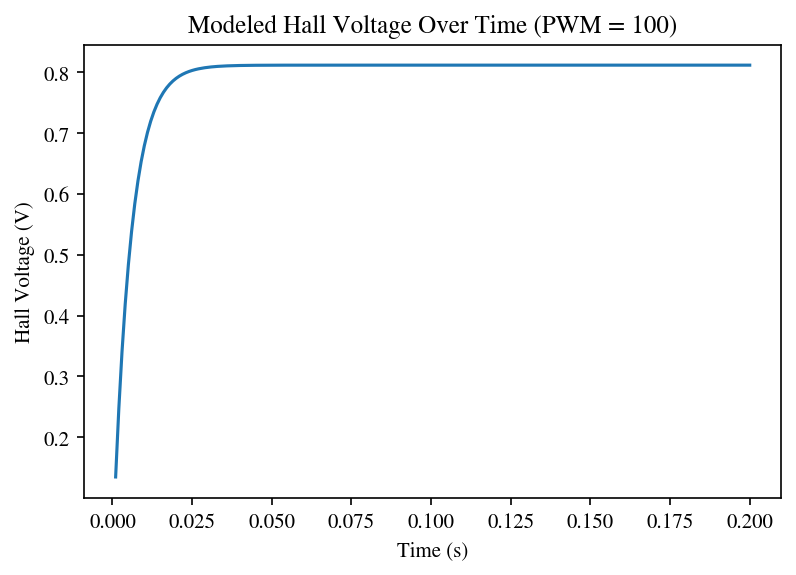

In [210]:
model = MagLevModel()
model.testHallVoltageFromElectromagnet(end_t = 0.2, test_PWM = 100)

plt.plot(model.ts, model.V_hs)
plt.title("Modeled Hall Voltage Over Time (PWM = 100)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Time (s)")

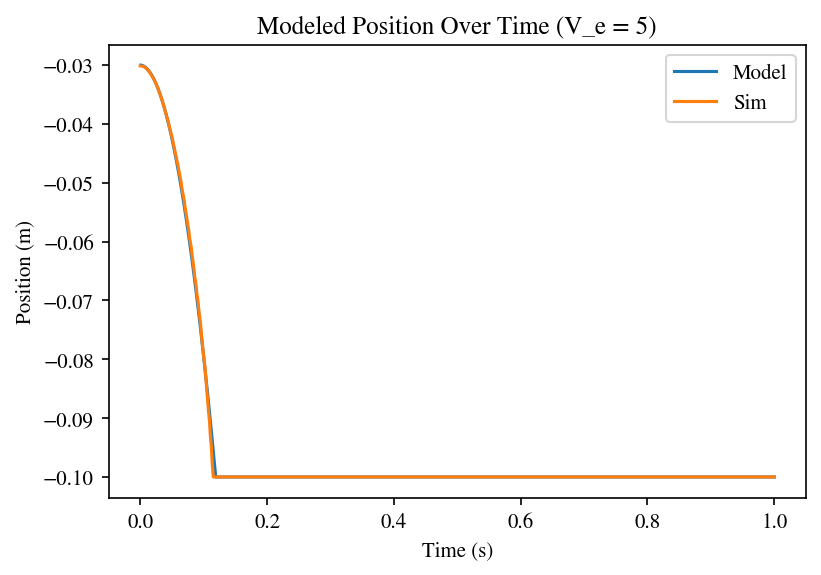

In [211]:
C = -0.034
# C = -0.041
model.testPosition(end_t = 1, test_V_e = 5)#5

plt.plot(model.ts, -np.array(model.ys[1:]), label='Model')
plt.plot(sim.t_list, -np.array(sim.y_list), label='Sim')
plt.title("Modeled Position Over Time (V_e = 5)")
plt.ylabel("Position (m)")
plt.xlabel("Time (s)")
plt.legend()

# Sketch Book

In [77]:
       
#     def testPositionComputation(self, end_t, test_PWM):
#         self.reset_model()

#         while self.t < end_t:
#             self.t += self.dt
            
#             model.set_amplifier_input(test_PWM, model.FORWARD)
            
#             # TODO: see if real model has a current limit
#             dI = ((self.V_e - self.I * R) / L) * self.dt
#             self.I += dI
            
#             self.V_h = currentToHallVoltage(self.I)
            
#             self.dist = convertToDistance(self.V_h, self.I)
            
#             self.ts.append(self.t)
#             self.Is.append(self.I)
#             self.V_hs.append(self.V_h)
#             self.ys.append(self.dist)
        
            
# #             self.ys = []
            
#                 # Update V_e based on controller 
#             # TODO
#             # TEMP
        



# model = MagLevModel()
# model.testPositionComputation(end_t = 0.2, test_PWM = 100)

# plt.plot(model.ts, model.ys)
# plt.title("Modeled Position Over Time (PWM = 100)")
# plt.ylabel("Position (m)")
# plt.xlabel("Time (s)")

In [78]:
# Does the magnet stick with no voltage?

# Create the system object.
sys_2 = mag_lev.MagLev()
# sys_2.

# Start the system.
sys_2.start_system()
sys_2.set_object_mass(3.0e-3)
sys_2.set_amplifier_input(255, sys_2.FORWARD)
sys_2.hold_magnet_at_distance(0)
sys_2.release_magnet()
time.sleep(10)
# sys_2.remove_magnet()

sys_2.stop_system()

Starting system...
System started
System stopped


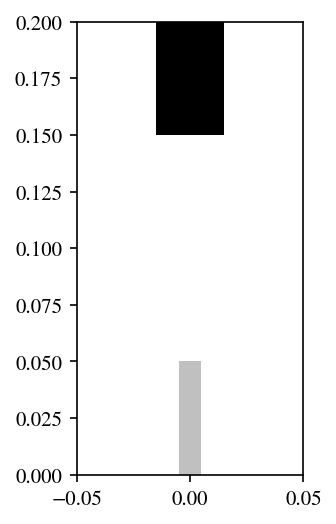

In [79]:
anim = sys_2.create_system_animation();

In [80]:
np.linspace(0, 0.1, 11)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [81]:
# # sys_1.set_amplifier_input(0, example_sys.FORWARD)
# # sys_1.set_amplifier_input(225, example_sys.FORWARD)

# while (time.time()-start_t < 1):
#     time_list.append(time.time() - start_t)
#     V_h_list.append((sys_1.get_hall_voltage()))

# # while (time.time()-start_t < 0.5):
# #     time_list.append(time.time() - start_t)
# #     V_h_list.append((sys_1.get_hall_voltage()))

# # sys_1.hold_magnet_at_distance(0.1)

# # while (time.time()-start_t < 1):
# #     time_list.append(time.time() - start_t)
# #     V_h_list.append((sys_1.get_hall_voltage()))

In [82]:
# Create the system object.
example_sys = mag_lev.MagLev()

# Start the system.
example_sys.start_system()

# Set the amplifier's maximum voltage.
example_sys.set_max_coil_voltage_magnitude(10.0)

# Set the amplifier's voltage.
example_sys.set_amplifier_input(200, example_sys.FORWARD)

# Choose an object mass.
example_sys.set_object_mass(3.0e-3)

# Hold the magnet under the electromagnet.
example_sys.hold_magnet_at_distance(3.0e-2)

# Wait a moment and then remove the magnet.
time.sleep(1.0)
example_sys.remove_magnet()

# Wait a moment and then hold the magnet under the electromagnet again at a
# different distance farther away.
time.sleep(1.0)
example_sys.hold_magnet_at_distance(5.0e-2)

# Wait a moment and then release the magnet.
print("Let's see if the magnet falls.")
time.sleep(1.0)
example_sys.release_magnet()

# Watch what happens for a bit.
start_time = time.time()
end_time = 2.0

while time.time() - start_time < end_time:
    # print(example_sys.get_hall_voltage())
    pass

# Wait a moment and then hold the magnet under the electromagnet again but
# much closer.
time.sleep(1.0)
example_sys.hold_magnet_at_distance(3.0e-2)

# Wait a moment and then release the magnet.
print("Let's see if the magnet sticks.")
time.sleep(1.0)
example_sys.release_magnet()

# Watch what happens for a bit again.
start_time = time.time()

while time.time() - start_time < end_time:
    pass
    # print(example_sys.get_hall_voltage())

# Wait a moment and stop the system.
time.sleep(1.0)
example_sys.stop_system()

# Wait a moment to make sure the system fully stopped.

# Note that all the other waits were as desired except the following wait
# as the system will not give an animation if the system is not fully
# stopped.
time.sleep(1.0)

# After running up to this point, the notebook is about 4.8 [kB].

Starting system...
System started
Let's see if the magnet falls.
Let's see if the magnet sticks.
System stopped


In [3]:
# Sometimes the below commands can be finicky or require a refresh of the page.
# Sometimes they just take a while to load. Sometimes minutes.
# Note that two plots always seem to show up (although unclear why).

In [14]:
# Take a look. Make sure all the above makes sense given the animation.
# For some reason, this line causes the animation to display (although not smoothly).
anim = example_sys.create_system_animation();
# After running up to this point, the notebook is about 5.5 [kB].

You cannot create an animation because the system is not stopped.


In [5]:
# Use pyplot as a default, but likely the playback will be poor.
# plt.show()

In [6]:
# To remove the animation object to shrink the notebook, 
# run the following command and rerun the cell containing the plot above.
%reset_selective -f anim

In [5]:
# A nice video can be produced with the following command. This could take maybe 30 [s].
anim_video = HTML(anim.to_html5_video())
# After running up to this point, the notebook is about 68.4 [kB].

In [6]:
# Display the video.
anim_video

In [ ]:
# In order to shrink the notebook (which is important), 
# run the following then rerun the above cell containing the video.
%reset_selective -f anim_video

In [12]:
sys_1.
# sys_1.get_hall_voltage()

<module 'time' (built-in)>

<IPython.core.display.Javascript object>


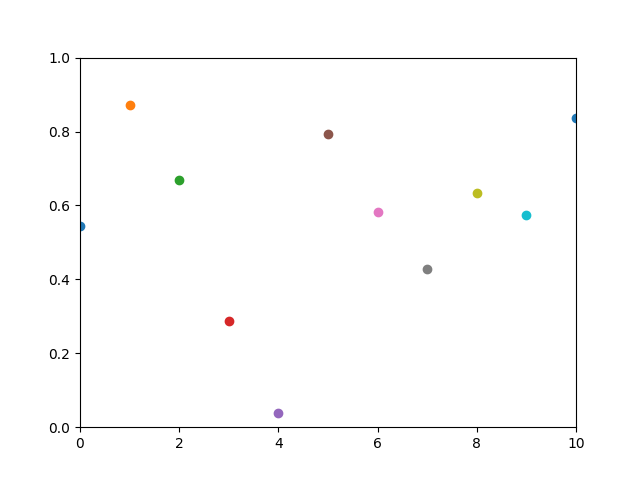

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plt.axis([0, 10, 0, 1])

for i in range(100):
    y = np.random.random()
    plt.scatter(i, y)
    plt.pause(0.05)

plt.show()

SyntaxError: invalid syntax (<ipython-input-130-f9be7de8f7b9>, line 1)